In [1]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow.keras.metrics as metrics
from keras_tuner import Objective

2023-09-15 15:00:20.636749: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("Resources/Aggregated_Metrics_By_Video.csv")
df

,Video,Video title,Video pub­lish time,Com­ments ad­ded,Shares,Dis­likes,Likes,Sub­scribers lost,Sub­scribers gained,RPM (USD),CPM (USD),Av­er­age per­cent­age viewed (%),Av­er­age view dur­a­tion,Views,Watch time (hours),Sub­scribers,Your es­tim­ated rev­en­ue (USD),Im­pres­sions,Im­pres­sions click-through rate (%)
0,Total,NaN,NaN,14197,39640,3902,225021,45790,229241,5.276,11.990,26.61,0:03:25,5568487,317602.3536,183451,29068.652,100954064,3.16
1,4OZip0cgOho,How I Would Learn Data Science (If I Had to St...,"May 8, 2020",907,9583,942,46903,451,46904,6.353,12.835,36.65,0:03:09,1253559,65850.7042,46453,7959.533,26498799,3.14
2,78LjdAAw0wA,100K Channel Update + AMA Stream!,"Nov 12, 2020",412,4,4,130,15,12,2.668,6.259,6.26,0:05:14,2291,200.2966,-3,6.113,188318,0.72
3,hO_YKK_0Qck,Uber Driver to Machine Learning Engineer in 9 ...,"Jul 16, 2020",402,152,15,881,9,198,9.516,11.695,15.12,0:10:21,21350,3687.3387,189,202.963,442334,2.53
4,uXLnbdHMf8w,Why I'm Starting Data Science Over Again.,"Aug 29, 2020",375,367,22,2622,40,1957,3.143,7.943,33.41,0:02:36,49564,2148.3110,1917,155.779,521185,4.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,FBgs-BSTIJE,Demystifying Data Science Roles,"Nov 30, 2018",3,5,1,48,1,8,5.218,16.232,55.55,0:03:28,978,56.5930,7,5.103,26202,2.24
220,Yr5T3T4tq-g,Most Data Science Hopefuls Overlook This Impor...,"May 25, 2019",3,0,0,44,0,5,3.374,15.596,58.62,0:02:06,548,19.2752,5,1.849,21780,1.61
221,j-Z-je6K4Yg,IT'S NOT TOO LATE TO LEARN CODE!,"Dec 18, 2018",3,1,0,35,0,7,3.784,12.590,60.52,0:01:52,721,22.5450,7,2.728,18635,2.65
222,5jntoZX-Tc8,NASA Physicist Turned Data Scientist (Tim Bowl...,"May 5, 2019",2,5,0,38,0,3,2.651,12.206,16.93,0:03:09,1094,57.6363,3,2.900,34642,1.99


In [3]:
# Drop the header line
df = df.drop(labels = 0, axis = 0)

In [4]:
df = df.drop(['Video', 'Video title', 'Video pub\xadlish time', 'Sub\xadscribers lost', 
                        'Sub\xadscribers gained', 'Av\xader\xadage per\xadcent\xadage viewed (%)', 
                        'Av\xader\xadage view dur\xada\xadtion', 'Sub\xadscribers', 
                        'Your es\xadtim\xadated rev\xaden\xadue (USD)', 'Im\xadpres\xadsions', 
                        'Im\xadpres\xadsions click-through rate (%)'], axis=1)

In [5]:
#Fix the two columns with "\xad" in it before starting
df.rename(columns = {'Com\xadments ad\xadded':'Comments added', 'Dis\xadlikes':'Dislikes'}, inplace=True)

In [6]:
#Since there are only two nulls, we'll just remove those two rows.
df = df.dropna(axis=0)

In [7]:
df.isna().sum()

Comments added        0
Shares                0
Dislikes              0
Likes                 0
RPM (USD)             0
CPM (USD)             0
Views                 0
Watch time (hours)    0
dtype: int64

In [8]:
df.columns

Index(['Comments added', 'Shares', 'Dislikes', 'Likes', 'RPM (USD)',
       'CPM (USD)', 'Views', 'Watch time (hours)'],
      dtype='object')

In [9]:
df["CPM (USD)"] = df["CPM (USD)"]*df["Views"]/1000

In [10]:
y = df["RPM (USD)"]*df["Views"]/1000

In [11]:
X = df.drop(["RPM (USD)", "Views"], axis = 1)

In [12]:
X.rename(columns = {"CPM (USD)": "Cost"}, inplace = True)

In [13]:
X

,Comments added,Shares,Dislikes,Likes,Cost,Watch time (hours)
1,907,9583,942,46903,16089.429765,65850.7042
2,412,4,4,130,14.339369,200.2966
3,402,152,15,881,249.688250,3687.3387
4,375,367,22,2622,393.686852,2148.3110
5,329,118,15,590,99.710325,1034.3945
...,...,...,...,...,...,...
218,4,5,0,30,46.287850,9.6188
219,3,5,1,48,15.874896,56.5930
220,3,0,0,44,8.546608,19.2752
221,3,1,0,35,9.077390,22.5450


In [14]:
y.mean()

132.21318380542988

In [15]:
X.mean()

Comments added          63.968326
Shares                 179.298643
Dislikes                17.638009
Likes                 1017.316742
Cost                   298.928293
Watch time (hours)    1436.927080
dtype: float64

In [16]:
y.max()

7963.860326999999

In [14]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [19]:
# find number of columns to find the input dimension
len(X.columns)

6

In [89]:
# Define the model with six hidden layers and an output layer with one unit
nn = Sequential()

# First hidden layer
nn.add(Dense(units=8, activation="relu", input_dim=6))

for i in range(5):
    nn.add(Dense(units=8, activation="relu"))

# Output layer
nn.add(Dense(units=1, activation='relu'))

# Check the structure of the model
nn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 8)                 56        
                                                                 
 dense_78 (Dense)            (None, 8)                 72        
                                                                 
 dense_79 (Dense)            (None, 8)                 72        
                                                                 
 dense_80 (Dense)            (None, 8)                 72        
                                                                 
 dense_81 (Dense)            (None, 8)                 72        
                                                                 
 dense_82 (Dense)            (None, 8)                 72        
                                                                 
 dense_83 (Dense)            (None, 1)               

In [90]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_percentage_error"])

In [91]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
6/6 [==============================] - 1s 1ms/step - loss: 428532.2188 - mean_absolute_percentage_error: 99.9402
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 428530.0312 - mean_absolute_percentage_error: 99.7468
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 428527.1875 - mean_absolute_percentage_error: 99.5363
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 428522.0938 - mean_absolute_percentage_error: 99.3070
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 428513.3438 - mean_absolute_percentage_error: 98.9968
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 428486.7500 - mean_absolute_percentage_error: 98.6788
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 428419.8750 - mean_absolute_percentage_error: 98.3190
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 428365.5625 - mean_absolute_percentage_error: 97.9795


6/6 [==============================] - 0s 2ms/step - loss: 97964.0156 - mean_absolute_percentage_error: 412.2297
Epoch 66/100
6/6 [==============================] - 0s 2ms/step - loss: 91433.6484 - mean_absolute_percentage_error: 421.8217
Epoch 67/100
6/6 [==============================] - 0s 2ms/step - loss: 66406.2656 - mean_absolute_percentage_error: 423.9007
Epoch 68/100
6/6 [==============================] - 0s 2ms/step - loss: 54972.8008 - mean_absolute_percentage_error: 422.1710
Epoch 69/100
6/6 [==============================] - 0s 2ms/step - loss: 45779.0195 - mean_absolute_percentage_error: 424.1030
Epoch 70/100
6/6 [==============================] - 0s 2ms/step - loss: 36298.1758 - mean_absolute_percentage_error: 427.9356
Epoch 71/100
6/6 [==============================] - 0s 2ms/step - loss: 29814.8340 - mean_absolute_percentage_error: 429.1631
Epoch 72/100
6/6 [==============================] - 0s 2ms/step - loss: 22615.8809 - mean_absolute_percentage_error: 426.6587
Epoch

In [92]:
# Evaluate the model using the test data
model_loss, model_percent_error = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Mean Absolute Percent Error: {model_percent_error}")

2/2 - 0s - loss: 7036.7100 - mean_absolute_percentage_error: 424.5189 - 107ms/epoch - 54ms/step
Loss: 7036.7099609375, Mean Absolute Percent Error: 424.5188903808594


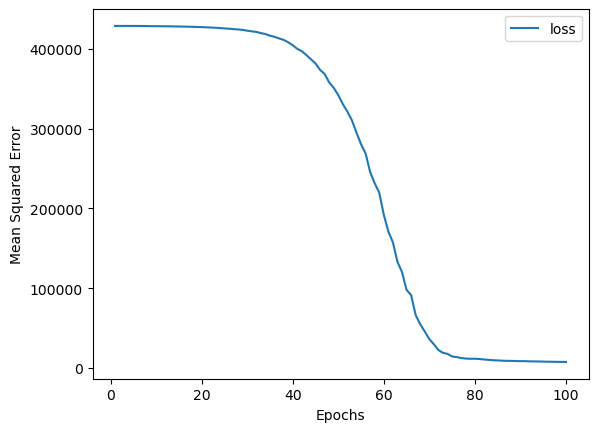

In [93]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.show()

Text(0.5, 0, 'Revenue')

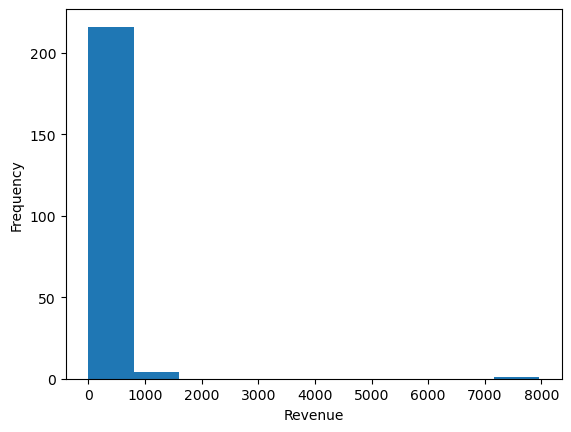

In [112]:
ax = y.plot.hist()
ax.set_xlabel("Revenue")

In [94]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn_2 = Sequential()

# First hidden layer
nn_2.add(Dense(units=8, activation="tanh", input_dim=6))

# Second hidden layer
nn_2.add(Dense(units=8, activation="tanh"))

# Third hidden layer
nn_2.add(Dense(units=8, activation="tanh"))

# Fourth hidden layer
nn_2.add(Dense(units=8, activation="tanh"))

# Fifth hidden layer
nn_2.add(Dense(units=8, activation="tanh"))

# Sixth hidden layer
nn_2.add(Dense(units=8, activation="tanh"))

# Output layer
nn_2.add(Dense(units=1, activation='relu'))

# Check the structure of the model
nn_2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 8)                 56        
                                                                 
 dense_85 (Dense)            (None, 8)                 72        
                                                                 
 dense_86 (Dense)            (None, 8)                 72        
                                                                 
 dense_87 (Dense)            (None, 8)                 72        
                                                                 
 dense_88 (Dense)            (None, 8)                 72        
                                                                 
 dense_89 (Dense)            (None, 8)                 72        
                                                                 
 dense_90 (Dense)            (None, 1)               

In [95]:
# Compile the model
nn_2.compile(loss="mean_absolute_percentage_error", optimizer="adam", metrics=["mean_squared_error"])

In [96]:
# Train the model
fit_model_2 = nn_2.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
6/6 [==============================] - 1s 2ms/step - loss: 97.5842 - mean_squared_error: 428516.9375
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 95.8093 - mean_squared_error: 428502.5938
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 93.9398 - mean_squared_error: 428488.0000
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 92.4809 - mean_squared_error: 428470.7812
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 90.9372 - mean_squared_error: 428454.1562
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 89.5653 - mean_squared_error: 428438.3125
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 88.2922 - mean_squared_error: 428421.0938
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 87.2870 - mean_squared_error: 428407.4062
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 86.5907 - mean_squared_er

6/6 [==============================] - 0s 2ms/step - loss: 78.6442 - mean_squared_error: 428095.0312
Epoch 73/100
6/6 [==============================] - 0s 2ms/step - loss: 78.6157 - mean_squared_error: 428091.6875
Epoch 74/100
6/6 [==============================] - 0s 2ms/step - loss: 78.5900 - mean_squared_error: 428088.8125
Epoch 75/100
6/6 [==============================] - 0s 2ms/step - loss: 78.5701 - mean_squared_error: 428080.8125
Epoch 76/100
6/6 [==============================] - 0s 2ms/step - loss: 78.5375 - mean_squared_error: 428073.9062
Epoch 77/100
6/6 [==============================] - 0s 2ms/step - loss: 78.5043 - mean_squared_error: 428068.0312
Epoch 78/100
6/6 [==============================] - 0s 2ms/step - loss: 78.4638 - mean_squared_error: 428056.9688
Epoch 79/100
6/6 [==============================] - 0s 2ms/step - loss: 78.4518 - mean_squared_error: 428052.9062
Epoch 80/100
6/6 [==============================] - 0s 2ms/step - loss: 78.4299 - mean_squared_error:

In [97]:
# Evaluate the model using the test data
model_loss, model_mean_squared_error = nn_2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Mean Squared Error: {model_mean_squared_error}")

2/2 - 0s - loss: 116.4671 - mean_squared_error: 24872.6465 - 112ms/epoch - 56ms/step
Loss: 116.46714782714844, Mean Squared Error: 24872.646484375


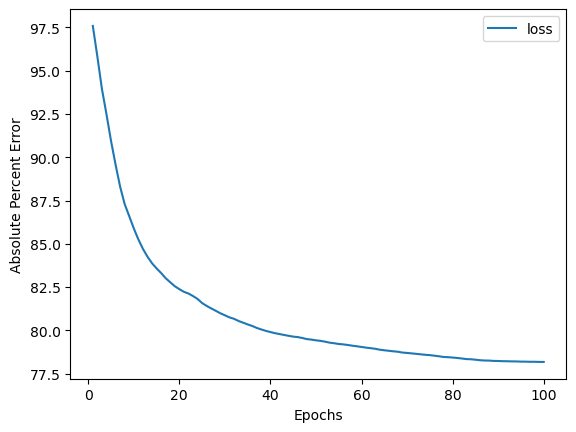

In [98]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model_2.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")
plt.xlabel("Epochs")
plt.ylabel("Absolute Percent Error")
plt.show()

In [27]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=15,
        step=5), activation=activation, input_dim=6))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 7)):
        nn_model.add(Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=15,
            step=5),
            activation=activation))

    nn_model.add(Dense(units=1, activation="relu"))

    # Compile the model
    nn_model.compile(loss="mean_squared_error", optimizer='adam',metrics = ['mean_squared_error'])

    return nn_model

In [28]:
# make a tuner object to find the best hyperparameters for mean squared error loss function

tuner = kt.Hyperband(
    create_model,
    objective='mean_squared_error',
    max_epochs=200,
    hyperband_iterations=2)

In [29]:
# Run the kerastuner search for best hyperparameters for mean squared error loss function
tuner.search(X_train_scaled,y_train,epochs=200,validation_data=(X_test_scaled,y_test))

Trial 508 Complete [00h 00m 13s]
mean_squared_error: 427781.125

Best mean_squared_error So Far: 2807.855224609375
Total elapsed time: 00h 30m 57s
INFO:tensorflow:Oracle triggered exit


In [30]:
# Find the best model for mean squared error loss function
top_model_mean_squared_error = tuner.get_best_models(1)[0]

model_loss = top_model.evaluate(X_test_scaled,y_test,verbose=1)
print(f"Loss: {model_loss}")

2/2 [==============================] - 0s 7ms/step - loss: 2249.4038 - mean_squared_error: 2249.4038
Loss: [2249.40380859375, 2249.40380859375]


In [31]:
# Find top model hyperparameters and print the values for mean squared error loss function
top_hyper = tuner.get_best_hyperparameters(1)
for param in top_hyper:
    print(param.values)

{'activation': 'relu', 'first_units': 6, 'num_layers': 7, 'units_0': 6, 'units_1': 6, 'units_2': 11, 'units_3': 11, 'units_4': 6, 'units_5': 11, 'units_6': 11, 'tuner/epochs': 200, 'tuner/initial_epoch': 67, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0396'}


In [32]:
top_model_mean_squared_error.save("Revenue_prediction_mean_squared_error.h5")

/Users/Shadow/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [99]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model_percent_error(hp):
    nn_model = Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=15,
        step=5), activation=activation, input_dim=6))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 7)):
        nn_model.add(Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=15,
            step=5),
            activation=activation))

    nn_model.add(Dense(units=1, activation="relu"))

    # Compile the model
    nn_model.compile(loss="mean_absolute_percentage_error", optimizer='adam',metrics = ['mean_absolute_percentage_error'])

    return nn_model

In [102]:
# make a tuner object to find the best hyperparameters using mean absolute percentage error

tuner = kt.Hyperband(
    create_model_percent_error,
    objective='mean_absolute_percentage_error',
    max_epochs=200,
    hyperband_iterations=2)

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [103]:
# Run the kerastuner search for best hyperparameters using mean absolute percentage error
tuner.search(X_train_scaled,y_train,epochs=200,validation_data=(X_test_scaled,y_test))

Trial 500 Complete [00h 00m 08s]
mean_absolute_percentage_error: 100.0

Best mean_absolute_percentage_error So Far: 26.52652931213379
Total elapsed time: 00h 17m 37s
INFO:tensorflow:Oracle triggered exit


In [105]:
# Find the best model for mean absolute percentage error
top_model_mean_absolute_percentage_error = tuner.get_best_models(1)[0]

model_loss = top_model_mean_absolute_percentage_error.evaluate(X_test_scaled,y_test,verbose=1)
print(f"Mean Absolute Percentage Error: {model_loss}")

2/2 [==============================] - 0s 4ms/step - loss: 37.8564 - mean_absolute_percentage_error: 37.8564
Mean Absolute Percentage Error: [37.856414794921875, 37.856414794921875]


In [107]:
# Find top model hyperparameters and print the values for mean absolute percentage error loss function
top_hyper_percent_loss = tuner.get_best_hyperparameters(1)
for param in top_hyper_percent_loss:
    print(param.values)

{'activation': 'relu', 'first_units': 6, 'num_layers': 4, 'units_0': 11, 'units_1': 11, 'units_2': 1, 'units_3': 11, 'units_4': 11, 'units_5': 6, 'units_6': 1, 'tuner/epochs': 200, 'tuner/initial_epoch': 67, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0221'}


In [108]:
top_model_mean_absolute_percentage_error.save("Revenue_prediction_absolute_percentage_error.h5")

/Users/Shadow/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [135]:
# Try to make a new model that doesn't overfit

top_model_tuner = top_hyper_percent_loss[0]
num_layers = 7
units =[]
for i in range(num_layers):
    units.append(top_model_tuner[f"units_{i}"])
activation = top_model_tuner["activation"]

relu


In [24]:
def make_model_final():
    # make the model specified in the hyper tuner
    nn = Sequential()

    # first hidden layer
    nn.add(Dense(units=6, activation = 'relu', input_dim =6))

    # Next five hidden layers    
    nn.add(Dense(units=11, activation='relu'))
    nn.add(Dense(units=11, activation='relu'))
    nn.add(Dense(units=1, activation='relu'))
    nn.add(Dense(units=11, activation='relu'))
    nn.add(Dense(units=11, activation='relu'))
    nn.add(Dense(units=6, activation='relu'))

    # output layer
    nn.add(Dense(units=1, activation='relu'))
    
    # compile the model
    nn.compile(loss="mean_absolute_percentage_error", \
                     optimizer="adam", metrics=["mean_absolute_percentage_error"])
    
    return nn

In [31]:
# create our model
nn_final = make_model_final()

In [29]:
# Check the structure of the model
nn_final.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 6)                 42        
                                                                 
 dense_25 (Dense)            (None, 11)                77        
                                                                 
 dense_26 (Dense)            (None, 11)                132       
                                                                 
 dense_27 (Dense)            (None, 1)                 12        
                                                                 
 dense_28 (Dense)            (None, 11)                22        
                                                                 
 dense_29 (Dense)            (None, 11)                132       
                                                                 
 dense_30 (Dense)            (None, 6)                

In [32]:
# Train the model
fit_model_final = nn_final.fit(X_train_scaled, y_train, epochs=200)

Epoch 1/200
6/6 [==============================] - 1s 2ms/step - loss: 99.9085 - mean_absolute_percentage_error: 99.9085
Epoch 2/200
6/6 [==============================] - 0s 2ms/step - loss: 99.4911 - mean_absolute_percentage_error: 99.4911
Epoch 3/200
6/6 [==============================] - 0s 2ms/step - loss: 98.9812 - mean_absolute_percentage_error: 98.9812
Epoch 4/200
6/6 [==============================] - 0s 2ms/step - loss: 98.4604 - mean_absolute_percentage_error: 98.4604
Epoch 5/200
6/6 [==============================] - 0s 2ms/step - loss: 97.8135 - mean_absolute_percentage_error: 97.8135
Epoch 6/200
6/6 [==============================] - 0s 2ms/step - loss: 97.4695 - mean_absolute_percentage_error: 97.4695
Epoch 7/200
6/6 [==============================] - 0s 3ms/step - loss: 97.2457 - mean_absolute_percentage_error: 97.2457
Epoch 8/200
6/6 [==============================] - 0s 2ms/step - loss: 96.8880 - mean_absolute_percentage_error: 96.8880
Epoch 9/200
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 88.5456 - mean_absolute_percentage_error: 88.5456
Epoch 69/200
6/6 [==============================] - 0s 2ms/step - loss: 88.5090 - mean_absolute_percentage_error: 88.5090
Epoch 70/200
6/6 [==============================] - 0s 2ms/step - loss: 88.5275 - mean_absolute_percentage_error: 88.5275
Epoch 71/200
6/6 [==============================] - 0s 2ms/step - loss: 88.2612 - mean_absolute_percentage_error: 88.2612
Epoch 72/200
6/6 [==============================] - 0s 2ms/step - loss: 88.1072 - mean_absolute_percentage_error: 88.1072
Epoch 73/200
6/6 [==============================] - 0s 2ms/step - loss: 88.1359 - mean_absolute_percentage_error: 88.1359
Epoch 74/200
6/6 [==============================] - 0s 2ms/step - loss: 87.9303 - mean_absolute_percentage_error: 87.9303
Epoch 75/200
6/6 [==============================] - 0s 2ms/step - loss: 87.8932 - mean_absolute_percentage_error: 87.8932
Epoch 76/200
6/6 [===================

Epoch 135/200
6/6 [==============================] - 0s 2ms/step - loss: 58.0106 - mean_absolute_percentage_error: 58.0106
Epoch 136/200
6/6 [==============================] - 0s 2ms/step - loss: 56.5790 - mean_absolute_percentage_error: 56.5790
Epoch 137/200
6/6 [==============================] - 0s 2ms/step - loss: 57.0017 - mean_absolute_percentage_error: 57.0017
Epoch 138/200
6/6 [==============================] - 0s 2ms/step - loss: 56.0264 - mean_absolute_percentage_error: 56.0264
Epoch 139/200
6/6 [==============================] - 0s 2ms/step - loss: 57.2692 - mean_absolute_percentage_error: 57.2692
Epoch 140/200
6/6 [==============================] - 0s 2ms/step - loss: 55.4782 - mean_absolute_percentage_error: 55.4782
Epoch 141/200
6/6 [==============================] - 0s 2ms/step - loss: 54.9485 - mean_absolute_percentage_error: 54.9485
Epoch 142/200
6/6 [==============================] - 0s 2ms/step - loss: 53.9511 - mean_absolute_percentage_error: 53.9511
Epoch 143/200
6/

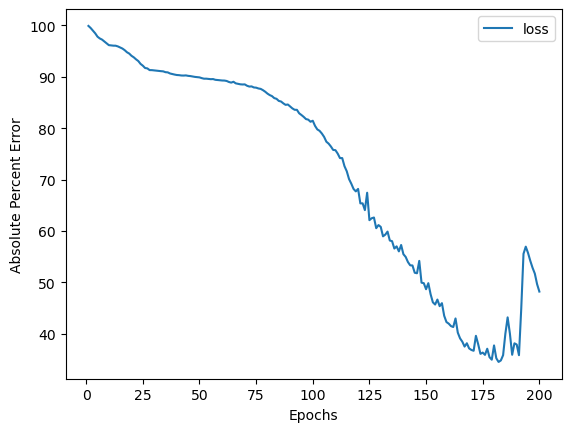

In [33]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model_final.history, index=range(1,len(fit_model_final.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")
plt.xlabel("Epochs")
plt.ylabel("Absolute Percent Error")
plt.show()

In [36]:
# create our model
nn_final = make_model_final()

# Train the model
fit_model_final = nn_final.fit(X_train_scaled, y_train, epochs=175)

Epoch 1/175
6/6 [==============================] - 1s 2ms/step - loss: 99.9154 - mean_absolute_percentage_error: 99.9154
Epoch 2/175
6/6 [==============================] - 0s 2ms/step - loss: 99.7300 - mean_absolute_percentage_error: 99.7300
Epoch 3/175
6/6 [==============================] - 0s 3ms/step - loss: 99.5315 - mean_absolute_percentage_error: 99.5315
Epoch 4/175
6/6 [==============================] - 0s 3ms/step - loss: 99.3400 - mean_absolute_percentage_error: 99.3400
Epoch 5/175
6/6 [==============================] - 0s 2ms/step - loss: 99.1444 - mean_absolute_percentage_error: 99.1444
Epoch 6/175
6/6 [==============================] - 0s 2ms/step - loss: 98.8864 - mean_absolute_percentage_error: 98.8864
Epoch 7/175
6/6 [==============================] - 0s 2ms/step - loss: 98.6719 - mean_absolute_percentage_error: 98.6719
Epoch 8/175
6/6 [==============================] - 0s 3ms/step - loss: 98.4249 - mean_absolute_percentage_error: 98.4249
Epoch 9/175
6/6 [===============

6/6 [==============================] - 0s 2ms/step - loss: 84.7197 - mean_absolute_percentage_error: 84.7197
Epoch 69/175
6/6 [==============================] - 0s 2ms/step - loss: 84.3088 - mean_absolute_percentage_error: 84.3088
Epoch 70/175
6/6 [==============================] - 0s 2ms/step - loss: 83.9110 - mean_absolute_percentage_error: 83.9110
Epoch 71/175
6/6 [==============================] - 0s 2ms/step - loss: 83.6079 - mean_absolute_percentage_error: 83.6079
Epoch 72/175
6/6 [==============================] - 0s 2ms/step - loss: 82.9968 - mean_absolute_percentage_error: 82.9968
Epoch 73/175
6/6 [==============================] - 0s 2ms/step - loss: 82.5008 - mean_absolute_percentage_error: 82.5008
Epoch 74/175
6/6 [==============================] - 0s 2ms/step - loss: 82.0669 - mean_absolute_percentage_error: 82.0669
Epoch 75/175
6/6 [==============================] - 0s 2ms/step - loss: 81.6394 - mean_absolute_percentage_error: 81.6394
Epoch 76/175
6/6 [===================

Epoch 135/175
6/6 [==============================] - 0s 2ms/step - loss: 67.3108 - mean_absolute_percentage_error: 67.3108
Epoch 136/175
6/6 [==============================] - 0s 2ms/step - loss: 67.0635 - mean_absolute_percentage_error: 67.0635
Epoch 137/175
6/6 [==============================] - 0s 2ms/step - loss: 66.8459 - mean_absolute_percentage_error: 66.8459
Epoch 138/175
6/6 [==============================] - 0s 2ms/step - loss: 66.5802 - mean_absolute_percentage_error: 66.5802
Epoch 139/175
6/6 [==============================] - 0s 2ms/step - loss: 66.3533 - mean_absolute_percentage_error: 66.3533
Epoch 140/175
6/6 [==============================] - 0s 2ms/step - loss: 66.0978 - mean_absolute_percentage_error: 66.0978
Epoch 141/175
6/6 [==============================] - 0s 2ms/step - loss: 65.8716 - mean_absolute_percentage_error: 65.8716
Epoch 142/175
6/6 [==============================] - 0s 2ms/step - loss: 65.5643 - mean_absolute_percentage_error: 65.5643
Epoch 143/175
6/

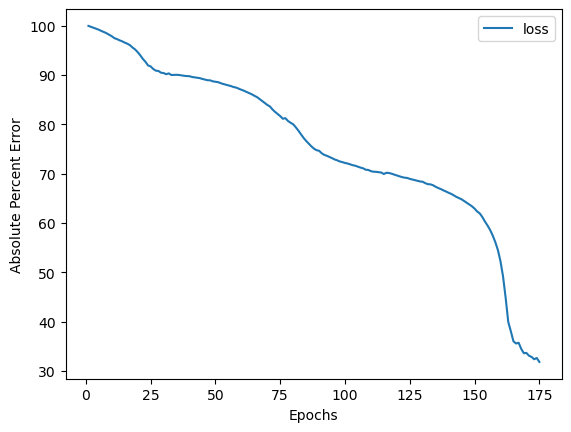

In [37]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model_final.history, index=range(1,len(fit_model_final.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")
plt.xlabel("Epochs")
plt.ylabel("Absolute Percent Error")
plt.show()

In [38]:
# Evaluate the model using the test data
model_loss = nn_final.evaluate(X_test_scaled,y_test,verbose=1)
print(f"Mean Absolute Percent Error: {model_loss}")

2/2 [==============================] - 0s 3ms/step - loss: 32.7416 - mean_absolute_percentage_error: 32.7416
Mean Absolute Percent Error: [32.741600036621094, 32.741600036621094]
